# Projet sante publique france

## Déjà réalisé



## Analyses univariées

In [1]:
import os
import re
from pprint import pprint

from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from matplotlib.offsetbox import (TextArea, DrawingArea,
                                  OffsetImage, AnnotationBbox)
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from tabulate import tabulate
import unicodedata
from wordcloud import WordCloud

from src.features.univar import UnivariateAnalysis
from src.visualization import visualize as viz

plt.rcdefaults()
font = {'size': 16}

sns.set()
plt.rc('font', **font)

In [2]:
%matplotlib inline

In [3]:
pd.options.display.max_rows = 999

In [4]:
# On récupère les données du second traitement
data = pd.read_pickle('../data/interim/products_interimV2.pickle')
univar = UnivariateAnalysis(data)

In [5]:
for col in data.columns:
    print(col)

code
product_name
brands
pnns_groups_1
pnns_groups_2
quantity
nutriscore_grade
main_category_en
energy_100g
proteins_100g
fat_100g
carbohydrates_100g
salt_100g
sodium_100g
saturated-fat_100g
sugars_100g
fiber_100g


In [6]:
data.shape

(104897, 17)

In [7]:
data['main_category_en'] = data['main_category_en'].astype('category')
data['nutriscore_grade'] = data['nutriscore_grade'].astype(pd.CategoricalDtype(ordered=True))

In [8]:
data['nutriscore_grade']

3          d
305        b
325        b
346        c
374        b
          ..
1120420    d
1120453    e
1120673    e
1120721    e
1120743    d
Name: nutriscore_grade, Length: 104897, dtype: category
Categories (5, object): [a < b < c < d < e]

In [9]:
data.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,saturated-fat_100g,sugars_100g,fiber_100g
count,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000
mean,1142.956728,8.220470,14.568127,26.250491,0.952633,0.381047,5.699674,12.837543,1.420947
std,768.592415,7.960314,17.752780,26.529786,2.191839,0.876739,8.352064,18.481892,3.206997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000
25%,482.000000,2.200000,1.590000,3.300000,0.080000,0.032000,0.400000,0.900000,0.000000
50%,1046.000000,6.200000,8.000000,14.000000,0.600000,0.240000,2.200000,3.600000,0.000000
75%,1653.000000,11.900000,22.800000,51.000000,1.300000,0.520000,8.100000,17.000000,1.800000
max,3979.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000


In [10]:
data.head()

,code,product_name,brands,pnns_groups_1,pnns_groups_2,quantity,nutriscore_grade,main_category_en,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,saturated-fat_100g,sugars_100g,fiber_100g
3,0000000000100,moutarde au moût de raisin,courte paille,Fat and sauces,Dressings and sauces,"(100.0, g)",d,Groceries,936.0,5.1,8.2,29.0,4.60,1.811024,2.2,22.0,0.0
305,0000000274739,Raviolini au Fromage de chèvre et Pesto,Comme J’Aime,Composite foods,One-dish meals,"(300.0, g)",b,Meals,455.0,4.4,4.2,12.5,0.60,0.240000,2.1,1.4,1.8
325,0000000491228,Entremets Crème Brulée,Comme j'aime,Milk and dairy products,Dairy desserts,"(20.0, g)",b,Dairies,1952.4,6.8,15.3,75.5,0.50,0.200000,11.2,69.8,0.1
346,00000024,Pommes séchées,Kazidomi,Fruits and vegetables,Dried fruits,"(125.0, g)",c,Plant-based foods and beverages,1222.0,2.0,0.5,65.0,0.03,0.012000,0.1,51.0,0.0
374,0000009125124,Compote de Pomme,Mx3,Fruits and vegetables,Fruits,"(40.0, g)",b,Plant-based foods and beverages,1577.0,1.5,0.5,93.0,0.02,0.008000,0.1,66.0,0.0


### Catégories

In [11]:
data['main_category_en'].value_counts()

Plant-based foods and beverages                                              25986
Snacks                                                                       18664
Dairies                                                                      12340
Meats                                                                         8910
Meals                                                                         6779
Beverages                                                                     5351
Groceries                                                                     5022
Frozen foods                                                                  3209
Seafood                                                                       2528
Fruit juices                                                                  2307
Desserts                                                                      2193
Canned foods                                                                  2097
Spre

In [99]:
wc = WordCloud(width=600, height=600, background_color='white',
               min_font_size=5, max_font_size=40, relative_scaling=0.2)
wc.generate_from_frequencies(data['main_category_en'].value_counts().to_dict())

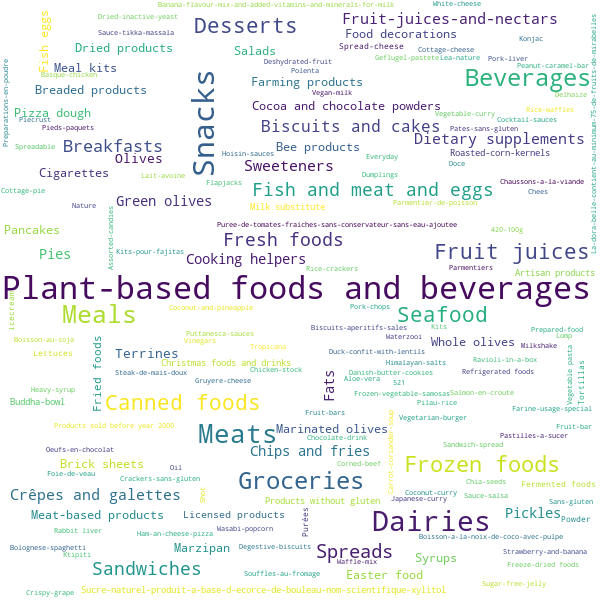

In [101]:
wc.to_image()

### Nutriscore et nutrigrade

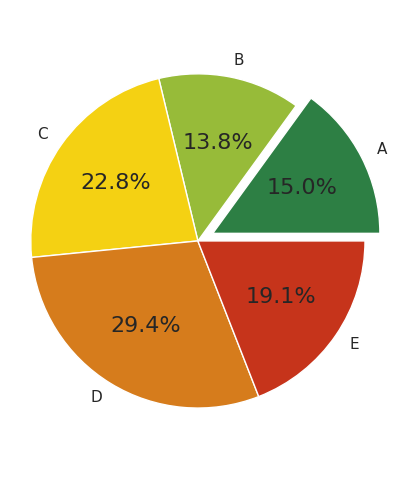

In [15]:
nutscore = ["#2D7F44", "#97BB39", "#F4D113", "#D67C1C", "#C6341B"]

g = viz.RepartitionPlot(data=data, var='nutriscore_grade',
                        plot_type='pie')
g.plot(colors=nutscore, explode=(0.1, 0, 0, 0, 0),
       autopct='%1.1f%%',)

### Valeurs _100g

Energie, protéines, graisse, sucres

completion rate -- energy_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
1142.9567277710516,768.5924148216291,0.0,3979.0,1046.0,590734.3001213431,482.0,1653.0


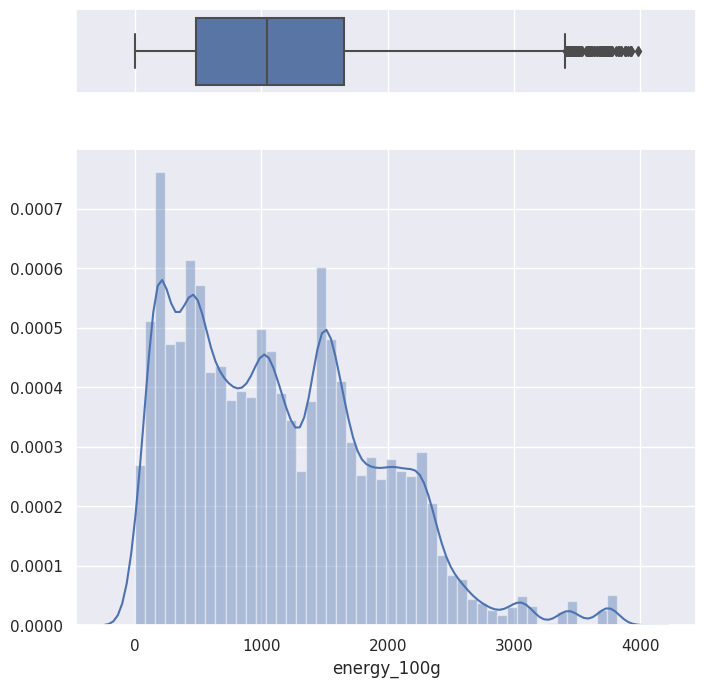

completion rate -- proteins_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
8.220469784199848,7.960314217241081,0.0,100.0,6.2,63.366602437210474,2.2,11.9


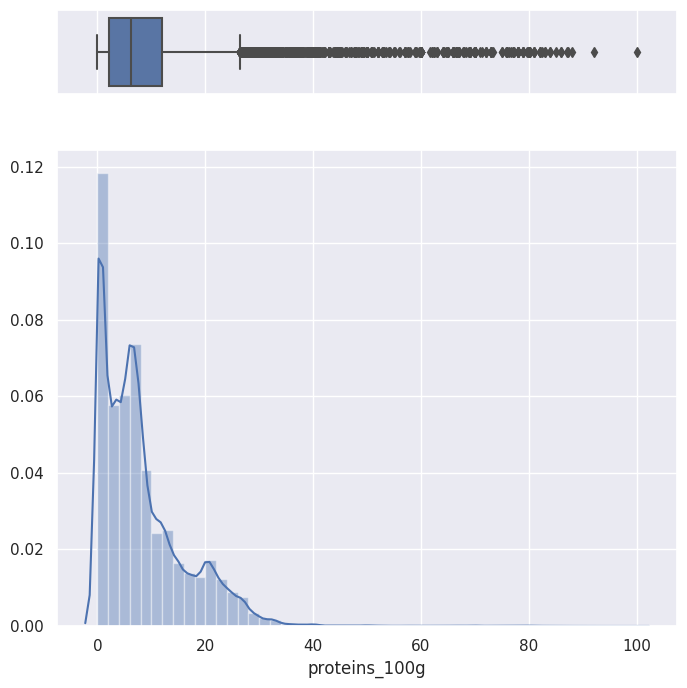

completion rate -- fat_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
14.568126645421014,17.752780209687728,0.0,100.0,8.0,315.16120517348025,1.59,22.8


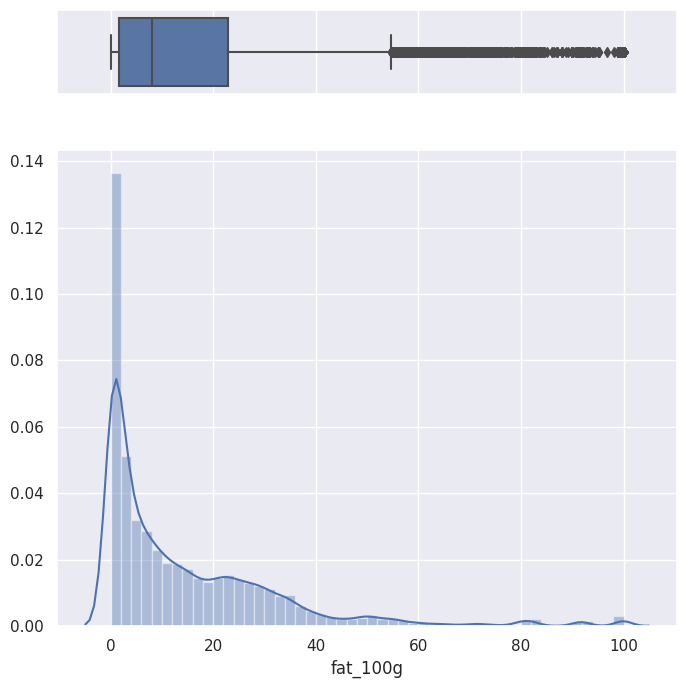

completion rate -- carbohydrates_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
26.25049135564061,26.529786181795696,0.0,100.0,14.0,703.8295548517979,3.3,51.0


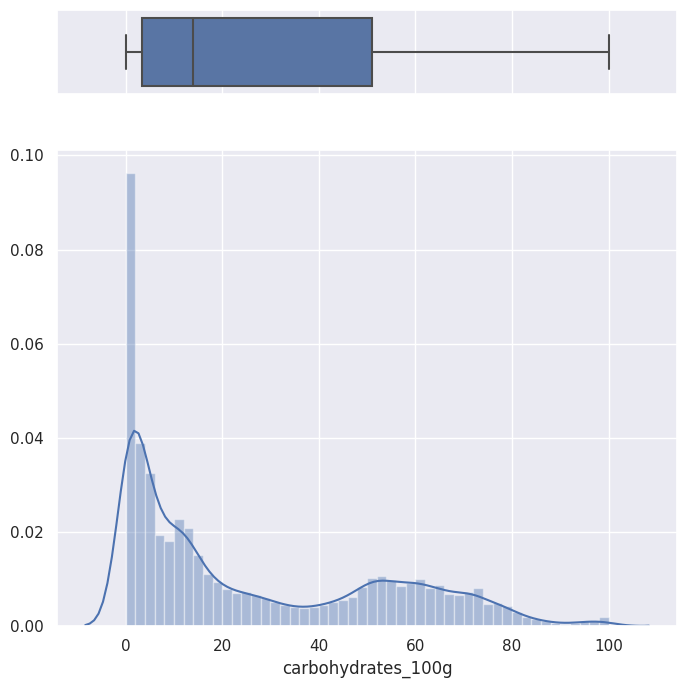

completion rate -- salt_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
0.952633110074365,2.1918394320502657,0.0,100.0,0.6,4.80416009589043,0.08,1.3


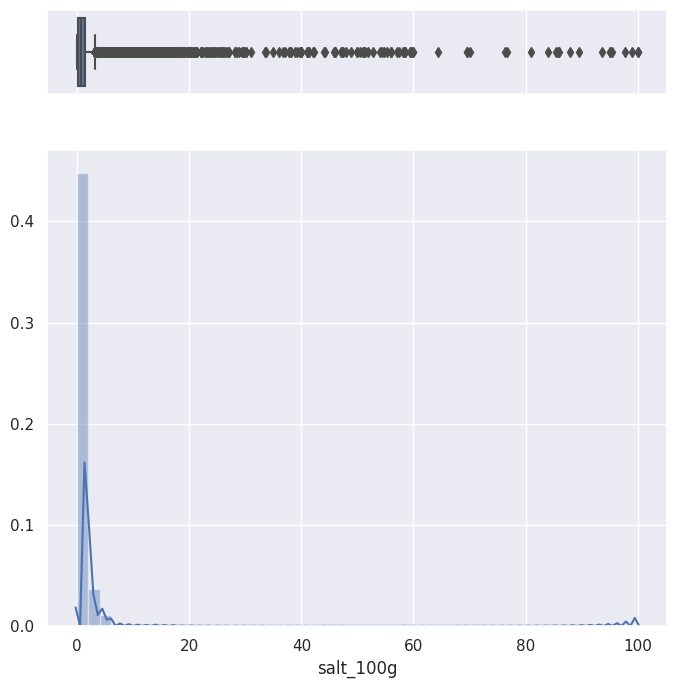

completion rate -- sodium_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
0.38104731792883667,0.8767392049341904,0.0,40.0,0.24,0.7686716334686364,0.032,0.52


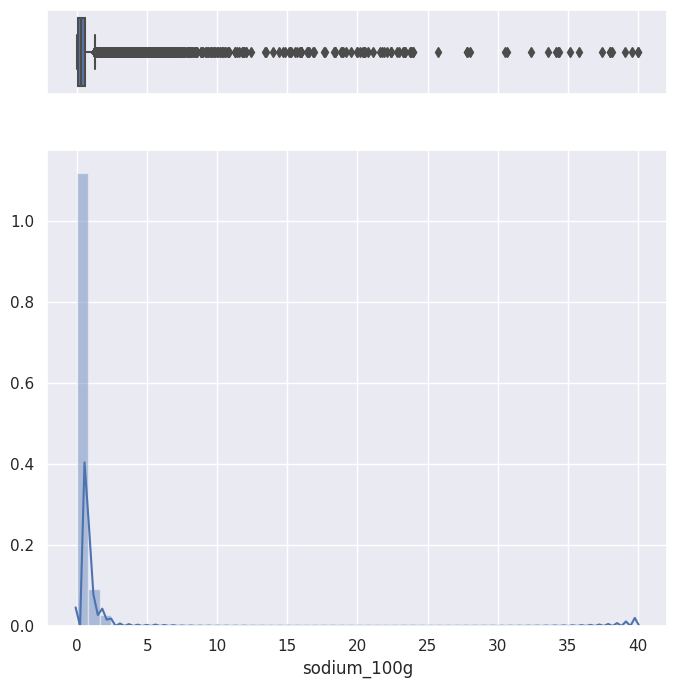

completion rate -- saturated-fat_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
5.699673919010188,8.352064027960214,0.0,100.0,2.2,69.756973527147,0.4,8.1


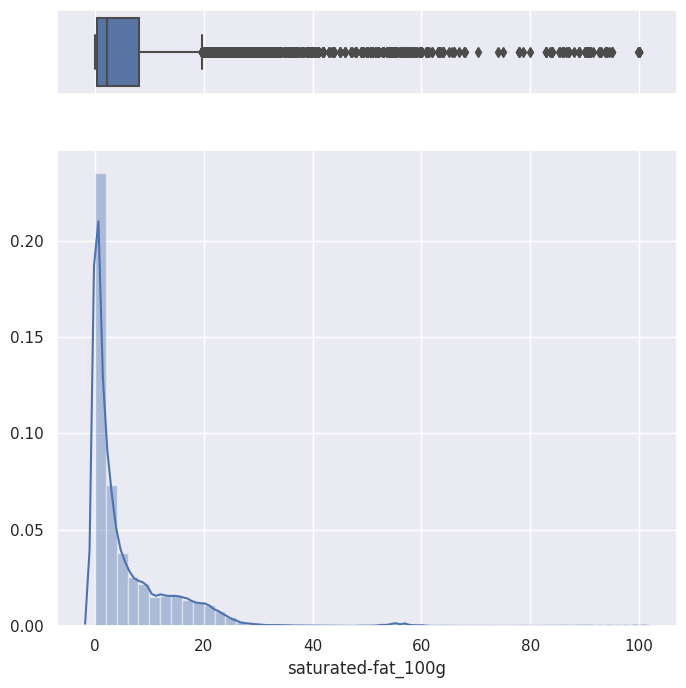

completion rate -- sugars_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
12.837543230636344,18.481891732878648,-0.1,100.0,3.6,341.58032202584815,0.9,17.0


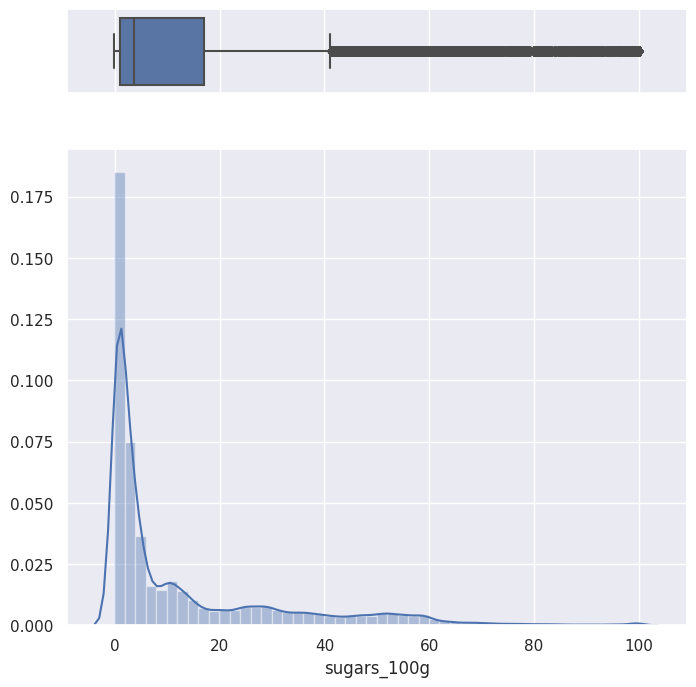

completion rate -- fiber_100g : 100.0 %


mean,std,min,max,median,variance,25%,75%
1.4209469464331679,3.2069965932087605,0.0,100.0,0.0,10.284827148852596,0.0,1.8


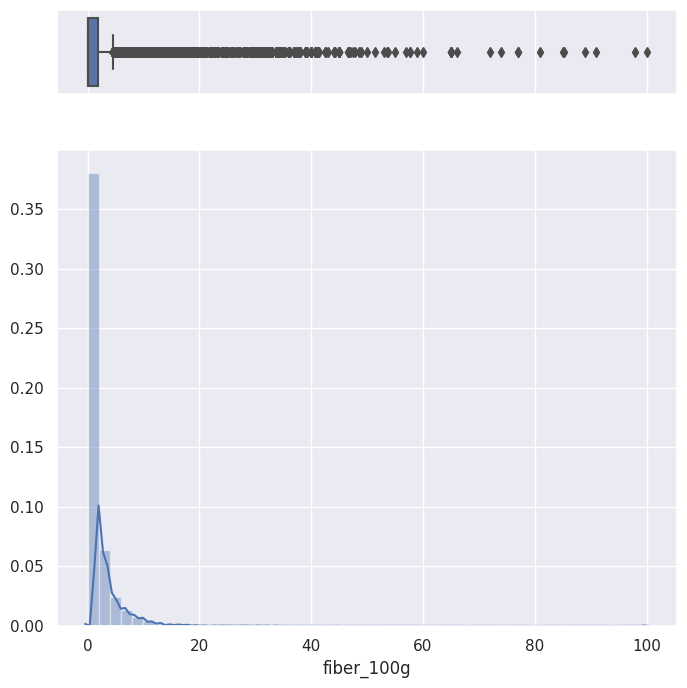

In [16]:
for col in data.columns:
    if col.endswith('_100g'):
        univar.make_analysis(col)

energy_100g
whishi 3406.0 whislo 0.0


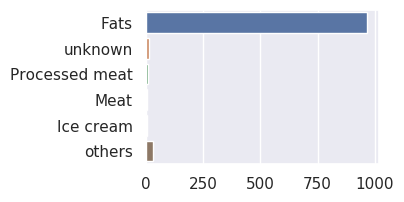

proteins_100g
whishi 26.44 whislo 0.0


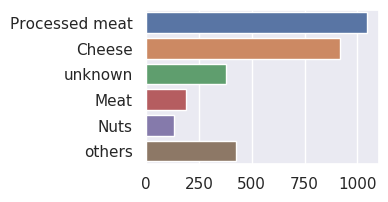

fat_100g
whishi 54.6 whislo 0.0


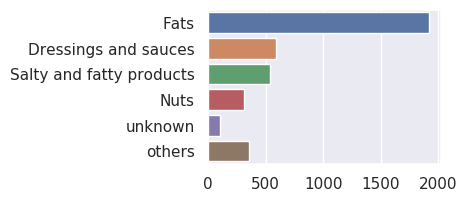

carbohydrates_100g
whishi 100.0 whislo 0.0
No outliers detected
salt_100g
whishi 3.13 whislo 0.0


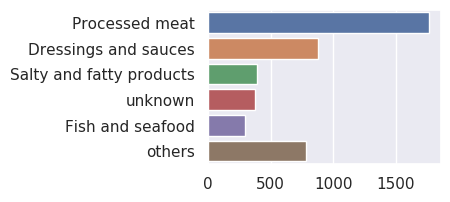

sodium_100g
whishi 1.252 whislo 0.0


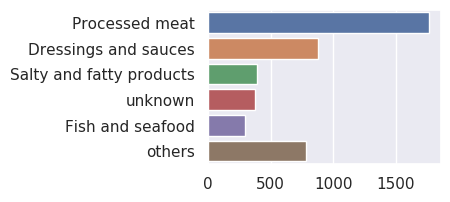

saturated-fat_100g
whishi 19.65 whislo 0.0


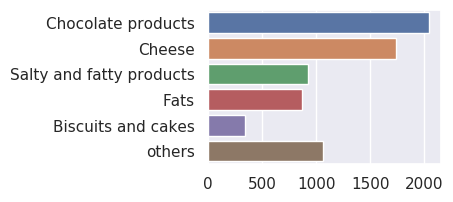

sugars_100g
whishi 41.1 whislo -0.1


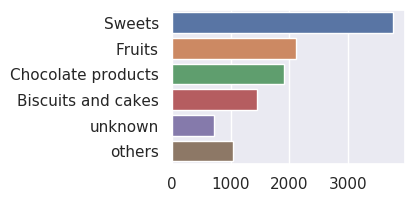

fiber_100g
whishi 4.5 whislo 0.0


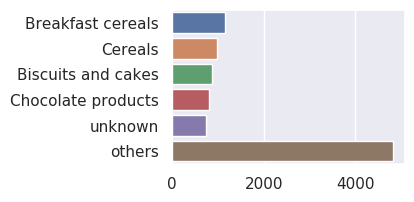

In [17]:
for col in data.columns:
    if col.endswith('_100g'):
        print('=' * 80)
        print(col)
        var = 'pnns_groups_2'
        box_stats = boxplot_stats(data[col]).pop(0)
        whishi = box_stats.get('whishi')
        whislo = box_stats.get('whislo')
        print('whishi', whishi, 'whislo', whislo)
        low = data[data[col] < whislo]
        high = data[data[col] > whishi]
        n_class = high[var].drop_duplicates().shape[0]
        if n_class > 5:
            n_class = 5
            others_cat = True
        if low.shape[0] > 0:
            g = viz.RepartitionPlot(data=low, var=var,
                                    plot_type='bar', max_class=n_class)
            g.plot(orient='h', figsize=(5, 2), others_cat=others_cat)
        elif high.shape[0] > 0:
            g = viz.RepartitionPlot(data=high, var=var,
                                    plot_type='bar', max_class=n_class)
            g.plot(orient='h', figsize=(3, 2), others_cat=others_cat)
        else:
            print("No outliers detected")
        plt.show()
        print('=' * 80)


### Marques

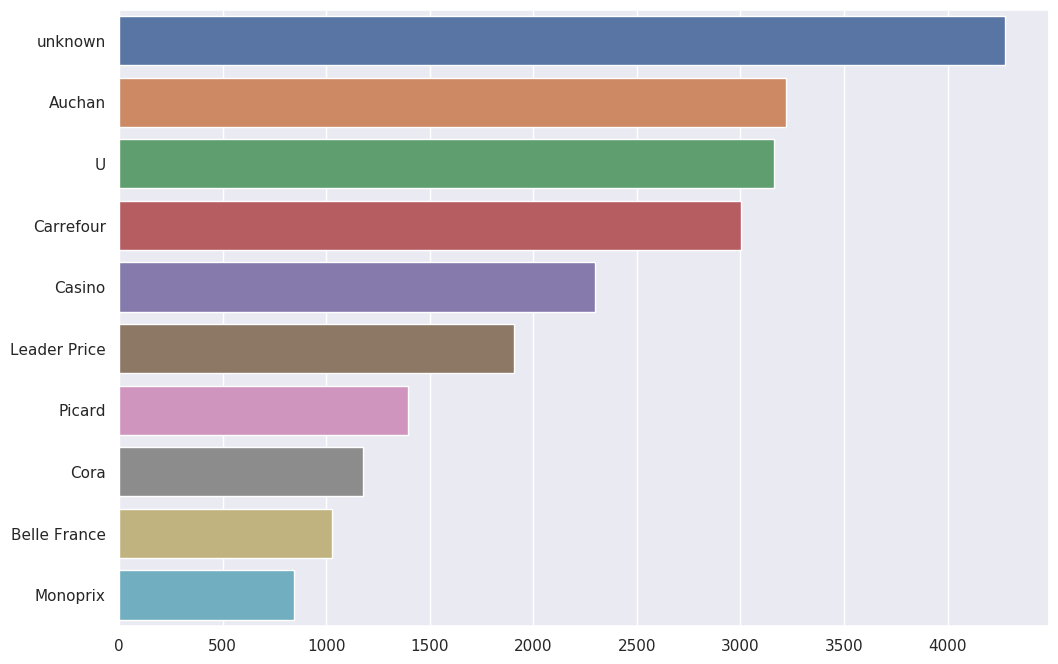

In [18]:
g = viz.RepartitionPlot(data=data, var='brands', plot_type='bar')
g.plot(others_cat=False, orient='h')

### PNNS groups

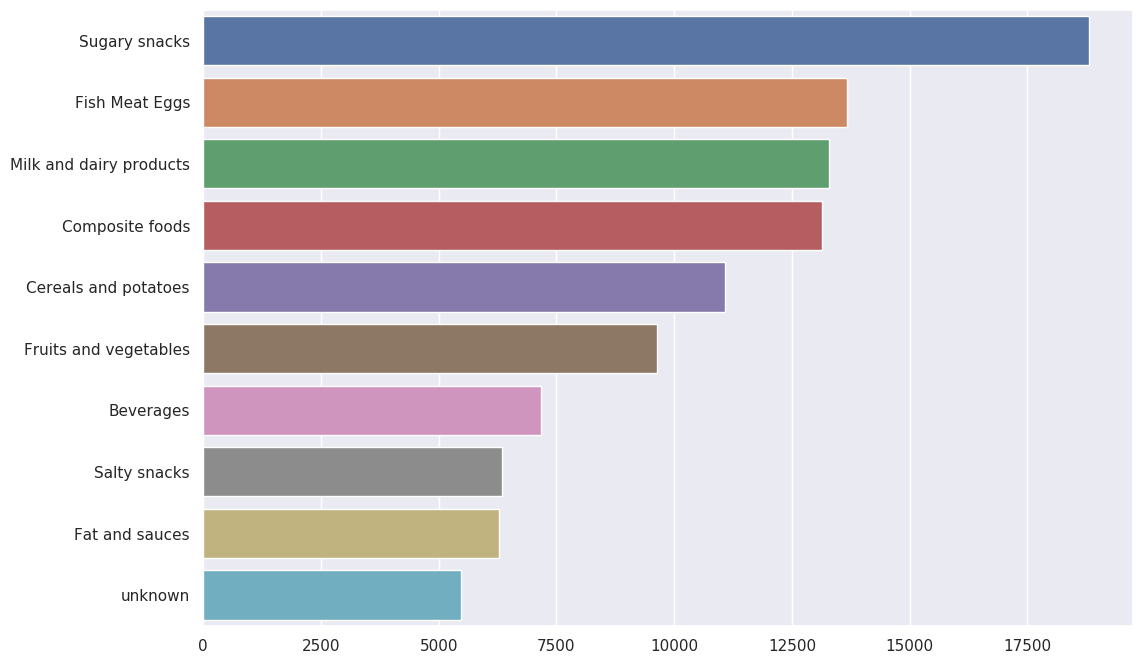

In [19]:
g = viz.RepartitionPlot(data=data, var='pnns_groups_1',
                        plot_type='bar', max_class=10)
g.plot(orient='h', others_cat=False)

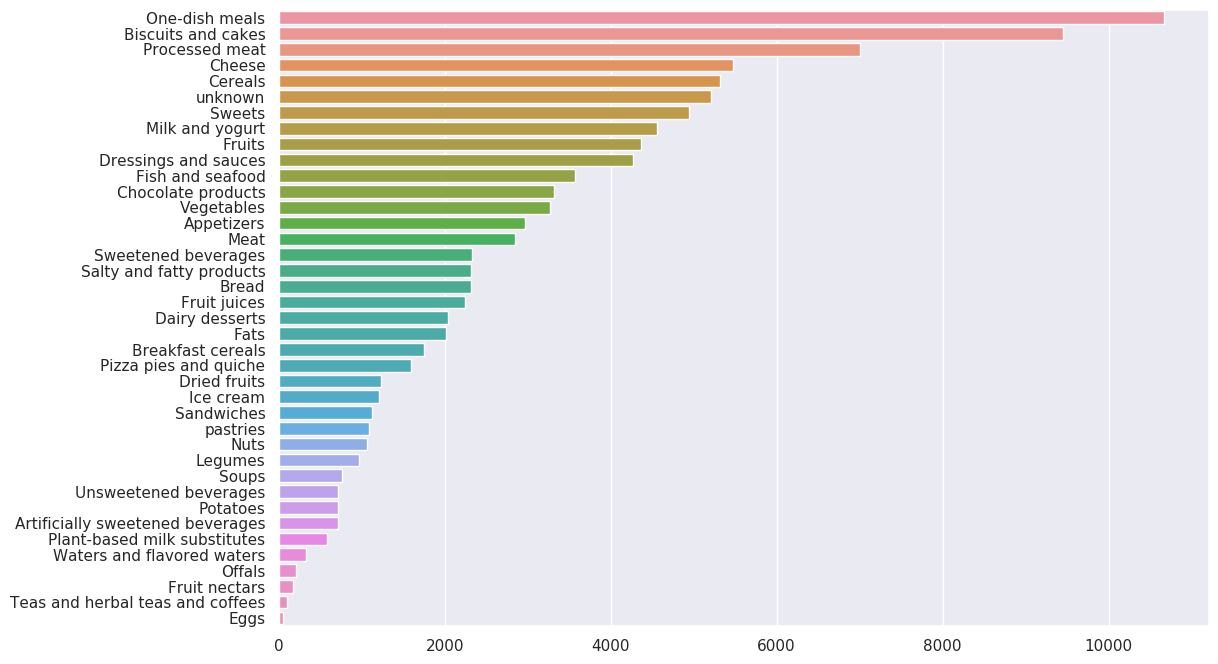

In [20]:
g = viz.RepartitionPlot(data=data, var='pnns_groups_2',
                        plot_type='bar', max_class=39)
g.plot(orient='h', others_cat=False)

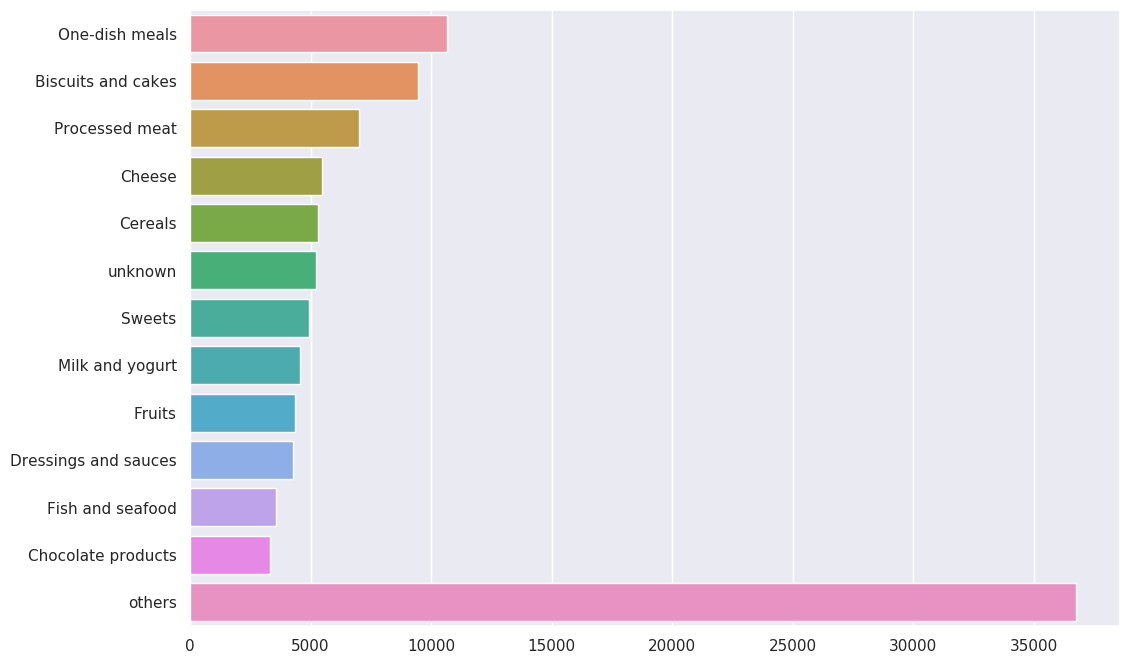

In [21]:
g = viz.RepartitionPlot(data=data, var='pnns_groups_2',
                        plot_type='bar', max_class=12)
g.plot(orient='h', others_cat=True)

## Bivariées

In [22]:
# TODO: stacked-bar, hue is hardcoded for now

### Marques / Nutriscore

In [23]:
nutriscore_logo = mpimg.imread('../reports/figures/logos/nutriscore.png')

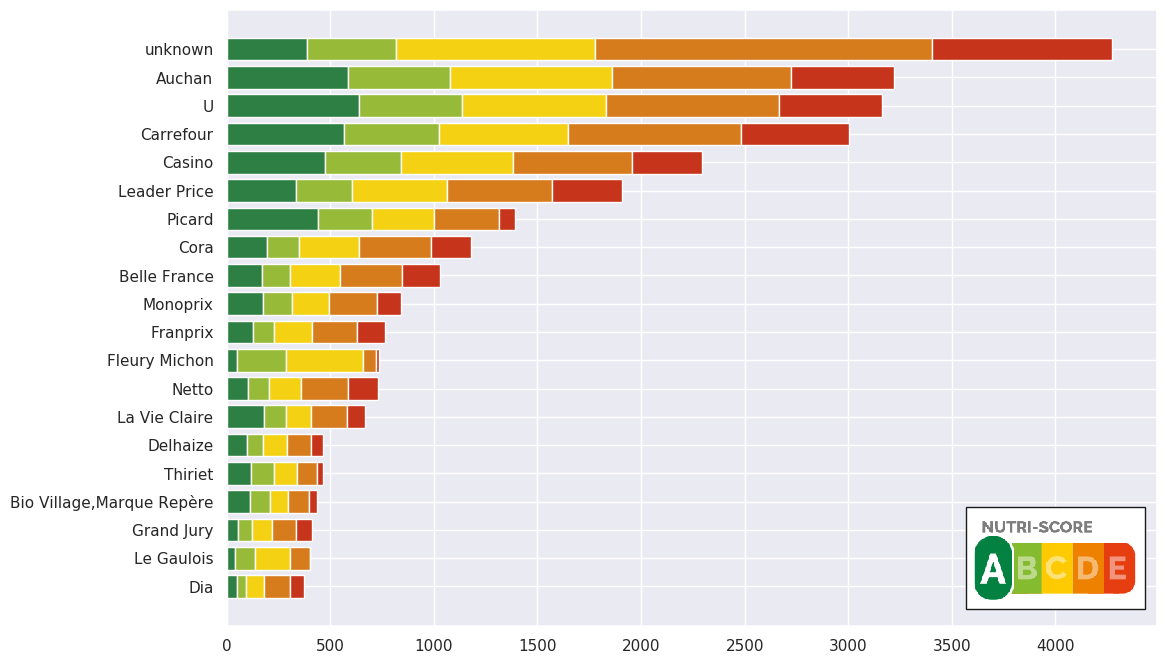

In [24]:
g = viz.RepartitionPlot(data=data, var='brands',
                        plot_type='stacked-bar', max_class=20)
g.plot(others_cat=False, colors=nutscore)

imagebox = OffsetImage(nutriscore_logo, zoom=0.5)
ab = AnnotationBbox(imagebox, (4000, 1))
ax = plt.gca()
ax.add_artist(ab)
ax.legend_ = None


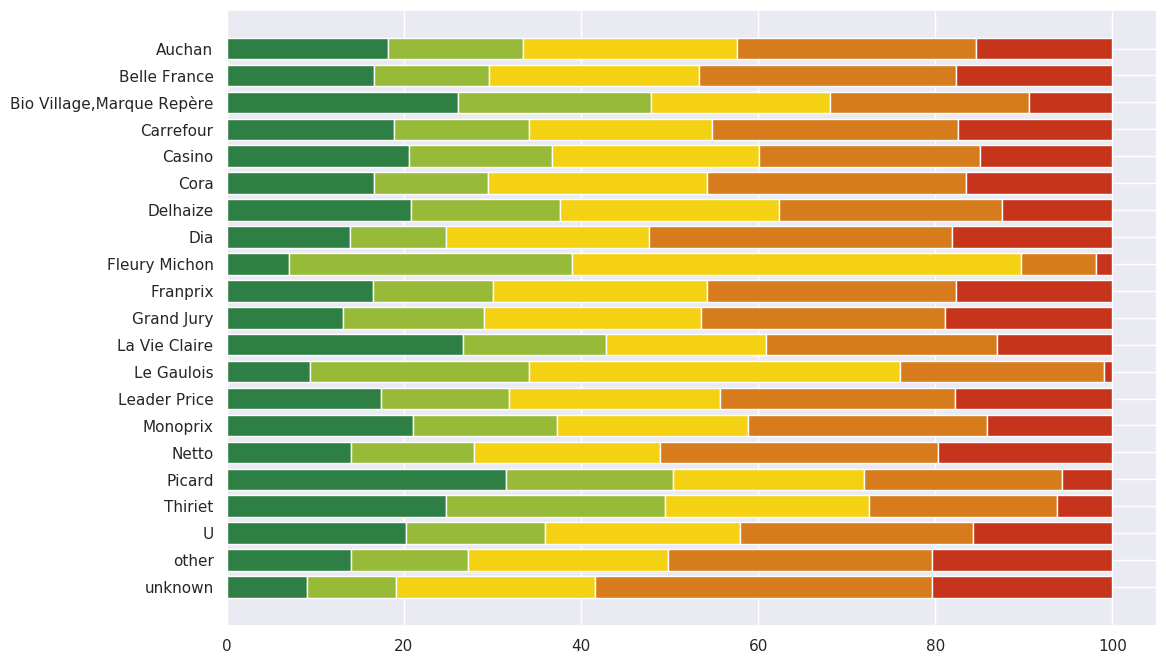

In [25]:
g = viz.RepartitionPlot(data=data, var='brands', plot_type='stacked-bar',
                        max_class=20)
g.plot(others_cat=True, colors=nutscore, frequency=True,
       sort='labels', ascending=False)

ax = plt.gca()
ax.legend_ = None

### PNNS groups / Nutriscore

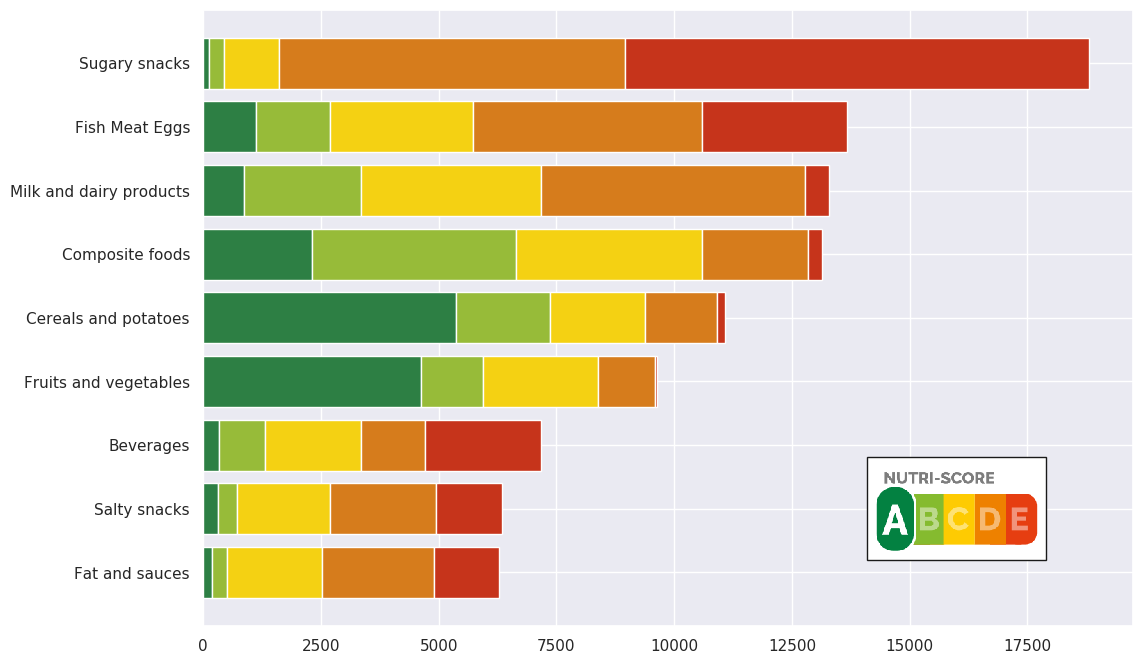

In [26]:
g = viz.RepartitionPlot(data=data, var='pnns_groups_1',
                        plot_type='stacked-bar', max_class=9)
g.plot(others_cat=False, orient='h', colors=nutscore)
imagebox = OffsetImage(nutriscore_logo, zoom=0.5)
ab = AnnotationBbox(imagebox, (16000, 1))
ax = plt.gca()
ax.add_artist(ab)
ax.legend_ = None

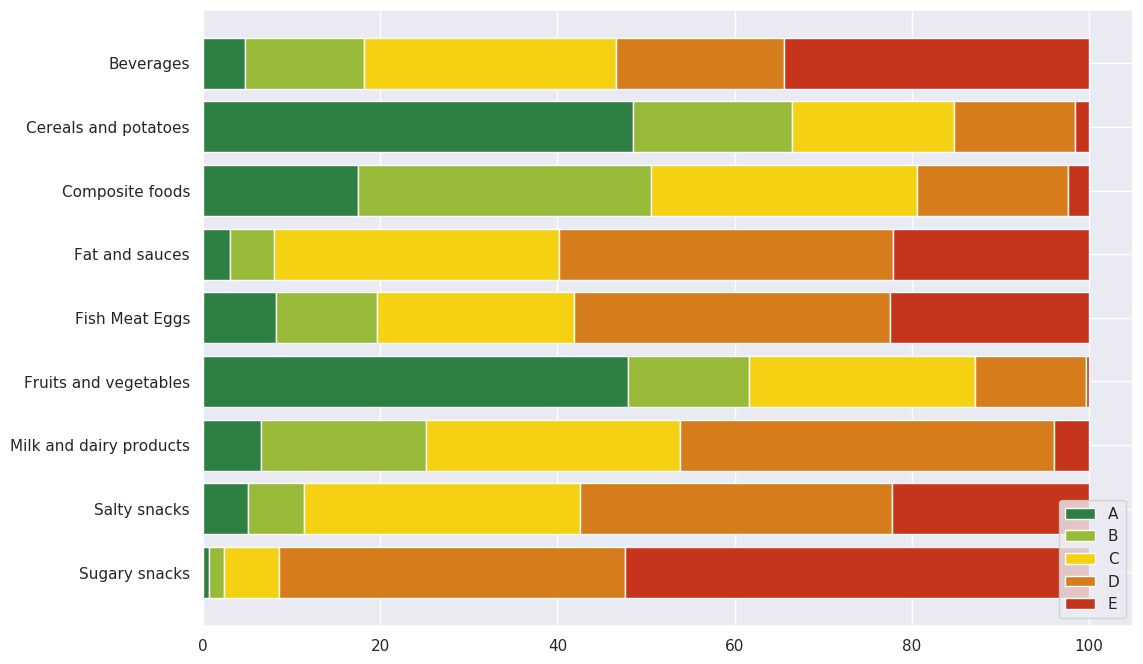

In [27]:
g = viz.RepartitionPlot(data=data, var='pnns_groups_1',
                        plot_type='stacked-bar', max_class=9)
g.plot(orient='h', colors=nutscore, others_cat=False, frequency=True,
       sort='labels', ascending=False)

In [28]:
cont = data.groupby(['pnns_groups_1', 'nutriscore_grade'])\
.size().reset_index().pivot(columns='pnns_groups_1', index='nutriscore_grade', values=0)
cont = cont.astype(int)

In [29]:
cont['Sum'] = cont.sum(axis=1)
cont

pnns_groups_1,Beverages,Cereals and potatoes,Composite foods,Fat and sauces,Fish Meat Eggs,Fruits and vegetables,Milk and dairy products,Salty snacks,Sugary snacks,unknown,Sum
nutriscore_grade,,,,,,,,,,,
a,335,5375,2303,192,1121,4621,871,319,116,487,15740
b,972,1984,4347,308,1564,1317,2478,401,322,737,14430
c,2038,2022,3946,2028,3041,2449,3814,1981,1181,1431,23931
d,1359,1520,2239,2367,4874,1215,5615,2239,7337,2029,30794
e,2473,168,311,1393,3071,27,517,1412,9848,782,20002


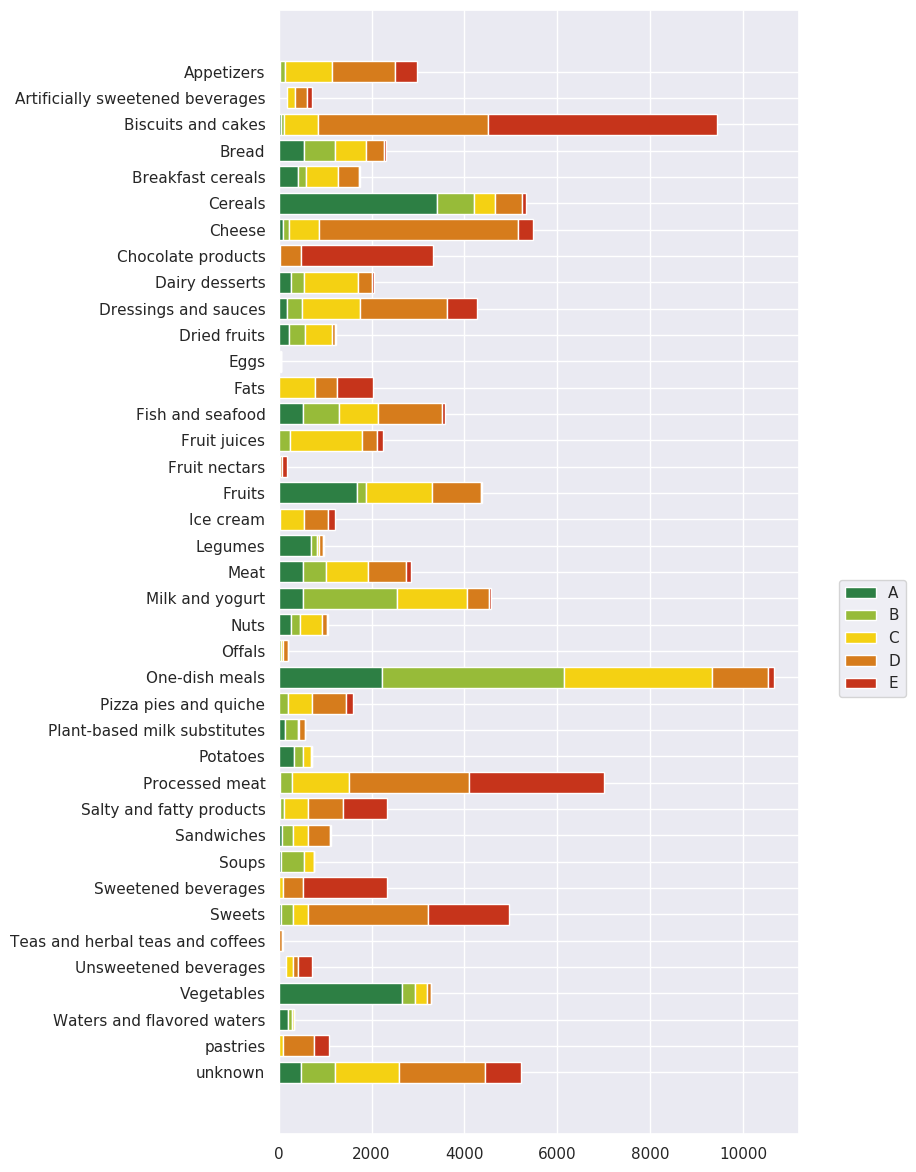

In [30]:
g = viz.RepartitionPlot(data=data, var='pnns_groups_2',
                        plot_type='stacked-bar',
                        max_class=45)
g.plot(orient='h', colors=nutscore, others_cat=False, frequency=False,
       sort='labels', ascending=False, figsize=(10, 12))
plt.legend(loc='upper right', bbox_to_anchor=(1.22, 0.5))
plt.tight_layout()
plt.savefig('./test.png', )

### Lien entre la valeur énergétique et les nutriments

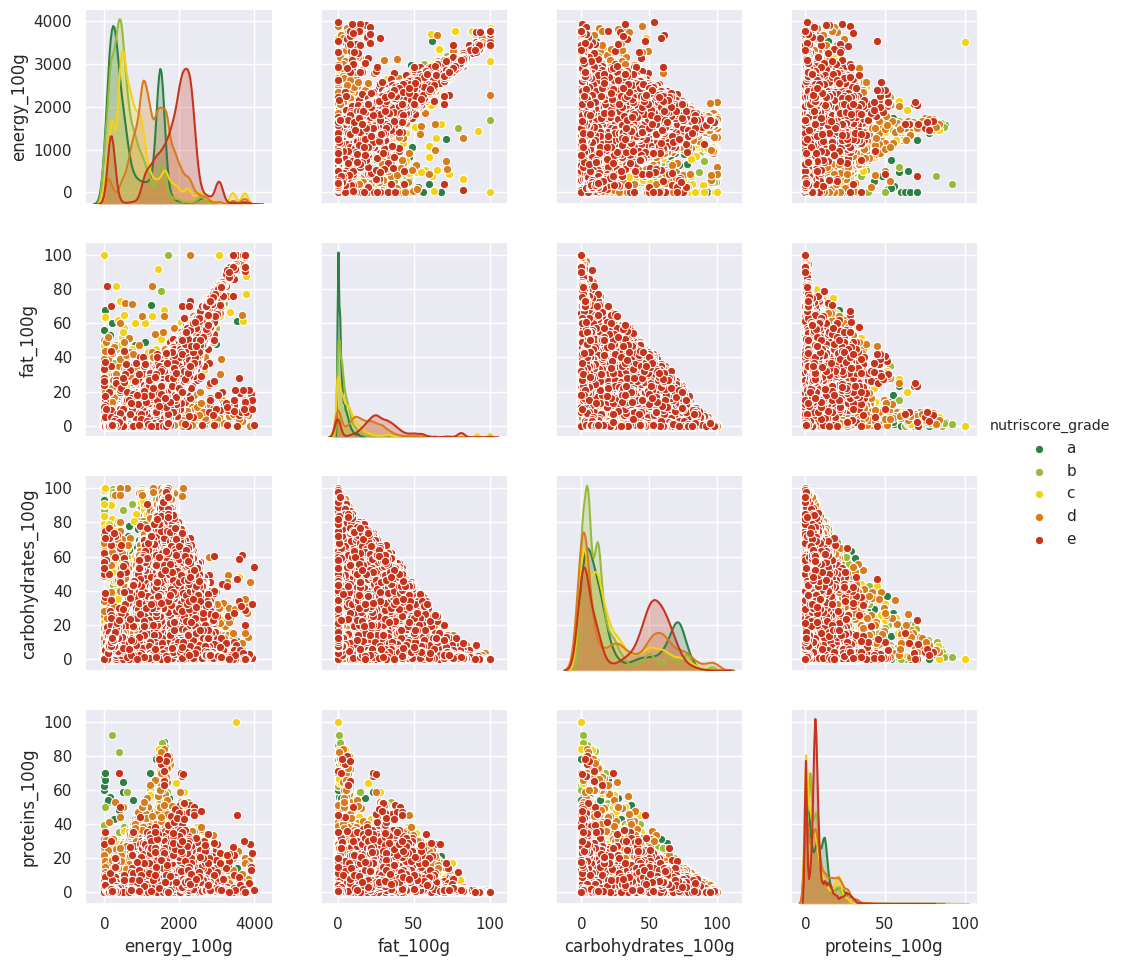

In [31]:
sns.pairplot(data[['energy_100g', 'fat_100g',
                   'carbohydrates_100g', 'proteins_100g',
                   'nutriscore_grade']], hue="nutriscore_grade",
             palette=nutscore)
plt.show()

### Valeur énergétique / Nutriscore

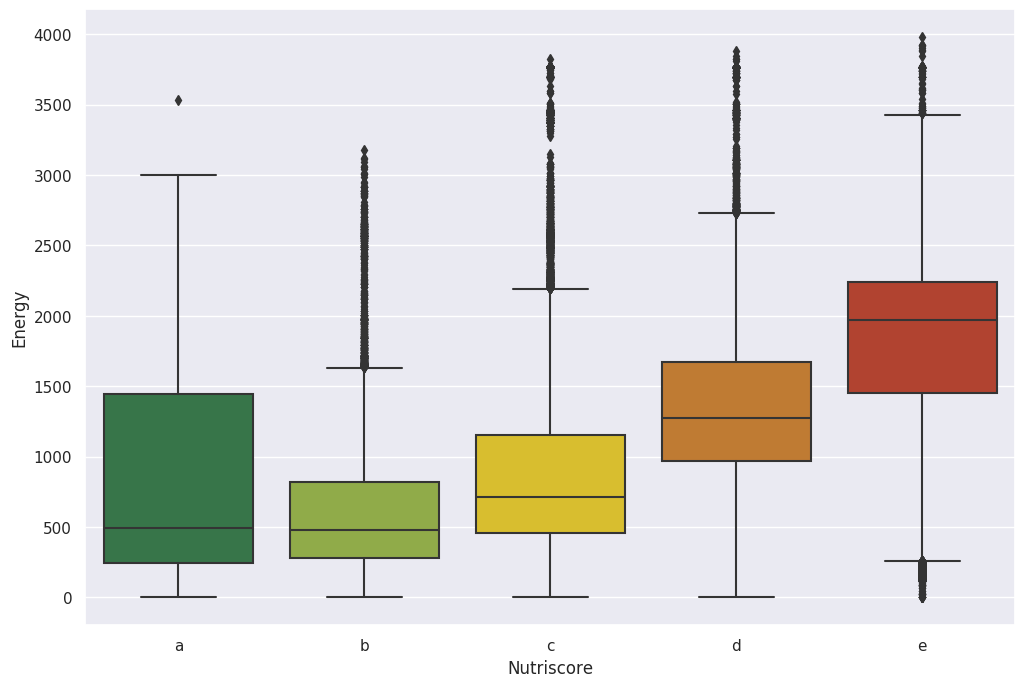

In [32]:
g = viz.RepartitionPlot(data=data, var='energy_100g', plot_type='boxplot')
g.plot(hue='nutriscore_grade', palette=nutscore)
plt.xlabel('Nutriscore')
plt.ylabel('Energy')
plt.show()

score A
whishi 3003.0 whislo 0.0


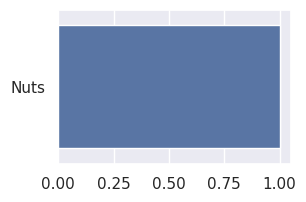

score B
whishi 1632.0 whislo 0.0


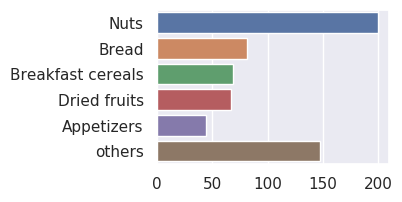

score C
whishi 2192.0 whislo 0.0


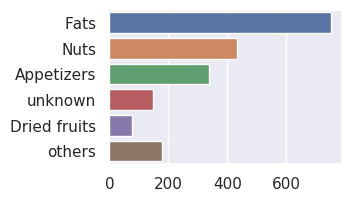

score D
whishi 2728.0 whislo 0.0


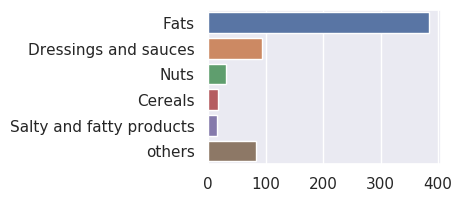

score E
whishi 3427.0 whislo 260.0


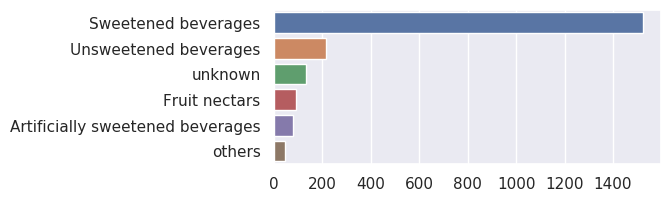

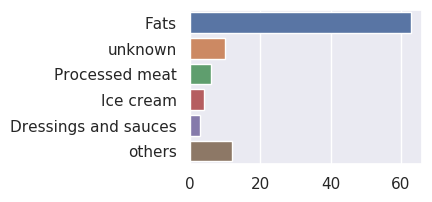

In [33]:
for score in range(ord('a'), ord('f')):
    var = 'pnns_groups_2'
    others_cat = False
    score = chr(score)
    print(f'score {score.upper()}')
    _data = data[data['nutriscore_grade'] == score]
    box_stats = boxplot_stats(_data['energy_100g']).pop(0)
    whishi = box_stats.get('whishi')
    whislo = box_stats.get('whislo')
    print('whishi', whishi, 'whislo', whislo)
    low = _data[_data['energy_100g'] < whislo]
    high = _data[_data['energy_100g'] > whishi]
    n_class = high[var].drop_duplicates().shape[0]
    if n_class > 5:
            n_class = 5
            others_cat = True
    if low.shape[0] > 0:
        g = viz.RepartitionPlot(data=low, var=var,
                                plot_type='bar', max_class=n_class)
        g.plot(orient='h', figsize=(5, 2), others_cat=others_cat)
    if high.shape[0] > 0:
        g = viz.RepartitionPlot(data=high, var=var,
                                plot_type='bar', max_class=n_class)
        g.plot(orient='h', figsize=(3, 2), others_cat=others_cat)
    plt.show()
    print('=' * 80)

### Valeur énergétique selon le groupe PNNS 1

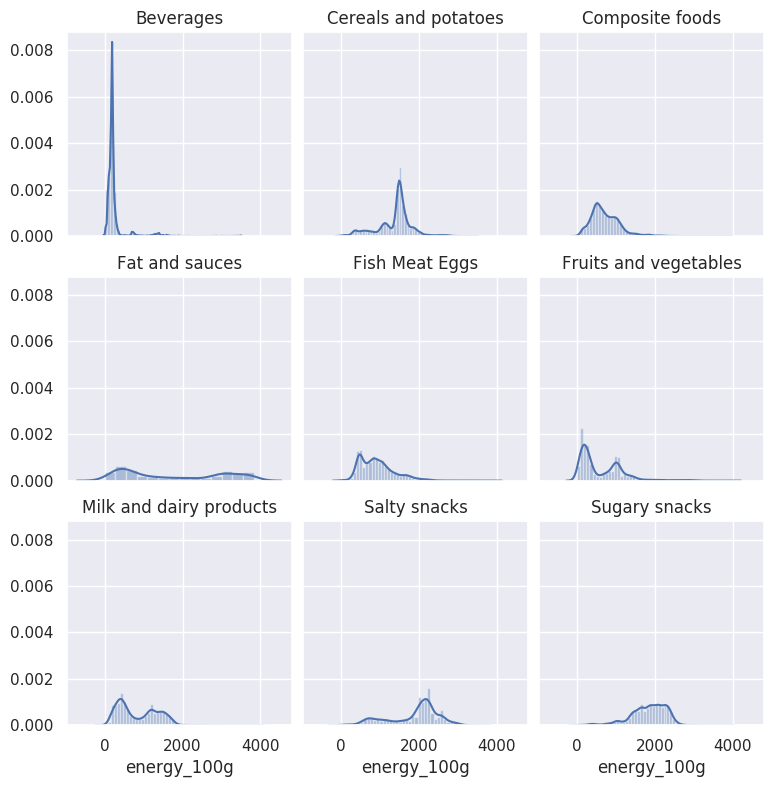

In [34]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 9))
pnns_groups = data['pnns_groups_1'].drop_duplicates().values
pnns_groups = pnns_groups.tolist()
pnns_groups.remove('unknown')
pnns_groups.sort()
for group, ax, i in zip(pnns_groups, axes.reshape(-1),
                     range(len(pnns_groups))):
    # print(group, ax)
    _data = data[data['pnns_groups_1'] == group]
    sns.distplot(_data['energy_100g'], ax=ax, kde=True)
    ax.set_title(group)
    if i < 6:
        ax.set_xlabel("")
plt.subplots_adjust(wspace=0.05, hspace=0.2)

### groupes PNNS: catégorie d'aliment et nutriments moyens /100g

Fat and sauces


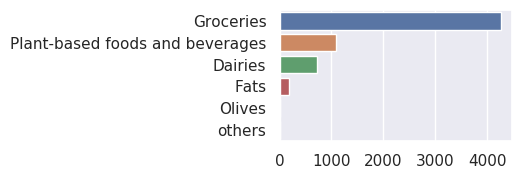

Composite foods


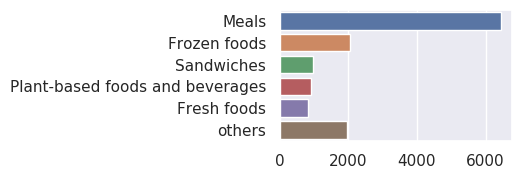

Milk and dairy products


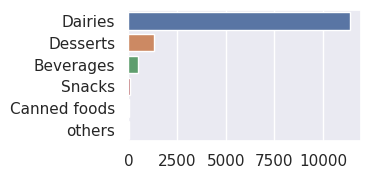

Fruits and vegetables


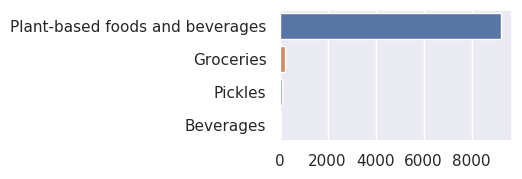

Sugary snacks


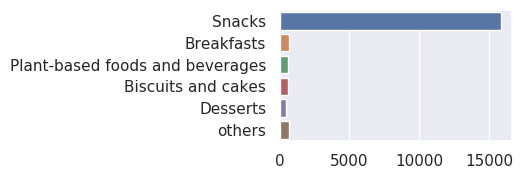

Beverages


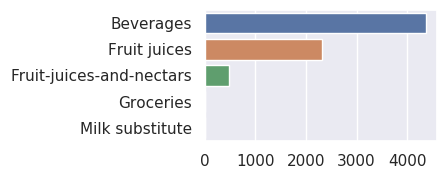

unknown


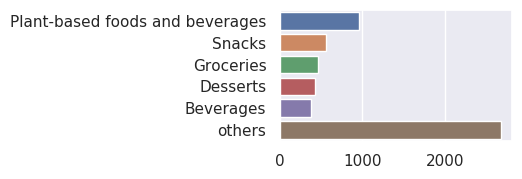

Salty snacks


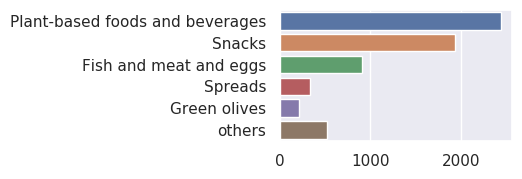

Fish Meat Eggs


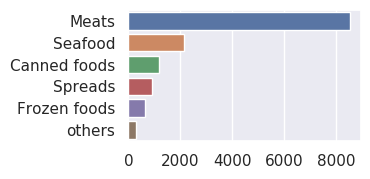

Cereals and potatoes


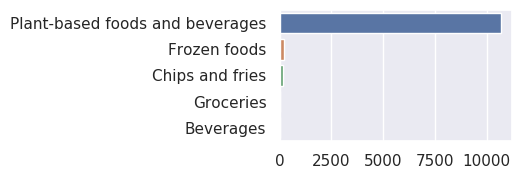

In [43]:
for group in data['pnns_groups_1'].drop_duplicates().values:
    print(group)
    n_class = len(data[data['pnns_groups_1'] == group]['main_category_en']\
    .drop_duplicates().values)
    others_cat = False
    if n_class > 5:
        n_class = 5
        others_cat = True
    g = viz.RepartitionPlot(data[data['pnns_groups_1'] == group], 
                            var='main_category_en', plot_type='bar',
                            max_class=n_class)
    g.plot(orient='h', figsize=(3, 1.7), others_cat=others_cat)
    plt.show()

Fat and sauces


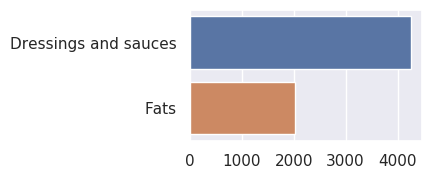

Composite foods


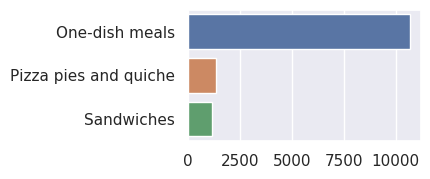

Milk and dairy products


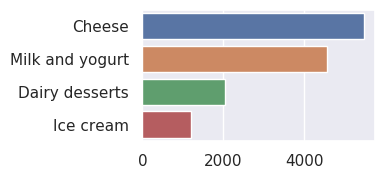

Fruits and vegetables


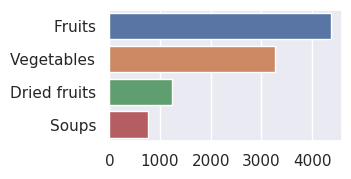

Sugary snacks


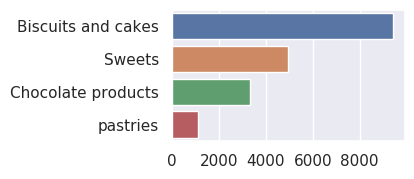

Beverages


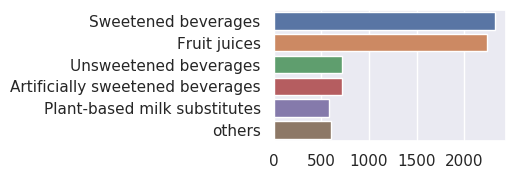

unknown


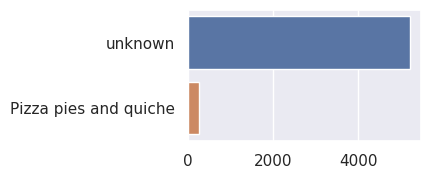

Salty snacks


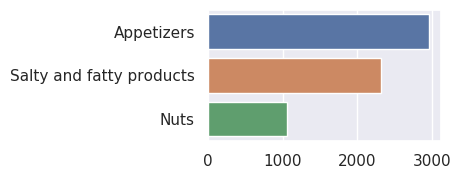

Fish Meat Eggs


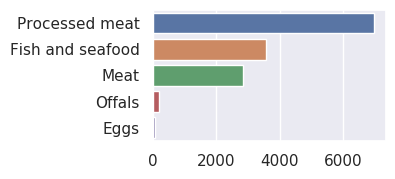

Cereals and potatoes


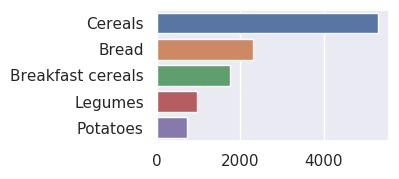

In [44]:
for group in data['pnns_groups_1'].drop_duplicates().values:
    print(group)
    n_class = len(data[data['pnns_groups_1'] == group]['pnns_groups_2']\
    .drop_duplicates().values)
    others_cat = False
    if n_class > 5:
        n_class = 5
        others_cat = True
    g = viz.RepartitionPlot(data[data['pnns_groups_1'] == group], 
                            var='pnns_groups_2', plot_type='bar',
                            max_class=n_class)
    g.plot(orient='h', figsize=(3, 1.7), others_cat=others_cat)
    plt.show()

Version control

In [37]:
commit = input('Commit ?')
if not commit:
    raise ValueError()

Commit ? 


ValueError: 

In [ ]:
!git commit ./3.0-tg-uni-bi-variate-analysis.ipynb -m "Automatic commit"